In [2]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader


from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
import subprocess

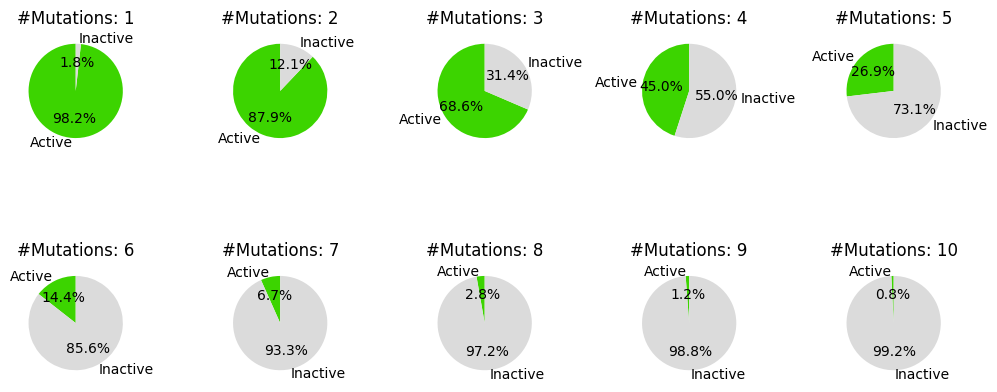

In [3]:
df = pd.read_csv("data/gfp_dataset_10mut.csv")

probabilities_by_mutations = []

for i in range(1, max(df["num_muts"].to_numpy() + 1)):
    df[df["num_muts"] == i].shape
    counts = np.unique(df[df["num_muts"] == i]["inactive"].astype(int), return_counts=True)

    row = np.concatenate([np.array([i]).astype(float), counts[1] / counts[1].sum()])
    probabilities_by_mutations.append(row)

labels = ['Active', 'Inactive']
sizes = np.stack(probabilities_by_mutations, axis=0)[-1, 1:]  # Last row, skip the mutation count column


fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.flatten()
for i in range(10):
    axs[i].pie(np.stack(probabilities_by_mutations, axis=0)[i, 1:], 
               labels=labels, 
               autopct='%1.1f%%', 
               startangle=90,
               colors=["#3cd400", "#dbdbdb"])
    axs[i].set_title("#Mutations: %d" % (i+1))
for i in range(10, len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.show()


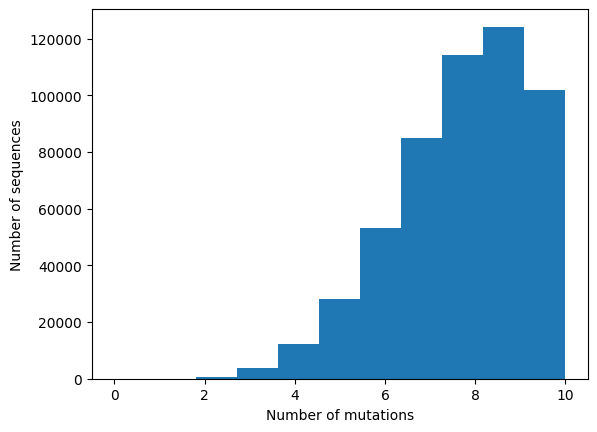

In [4]:
plt.figure()
plt.hist(df["num_muts"], bins=11)
plt.xlabel("Number of mutations")
plt.ylabel("Number of sequences")
plt.show()

def get_one_hot_encoding(sdf, first_col, last_col):
    si = np.where(sdf.columns == first_col)[0][0]
    ei = np.where(sdf.columns == last_col)[0][0]
    
    one_hot_encoding = torch.from_numpy(pd.get_dummies(sdf[sdf.columns[si:(ei+1)]]).to_numpy()).to(torch.int64)

    return(one_hot_encoding)
    

df = pd.read_csv("data/gfp_dataset_10mut.csv")
one_hot = get_one_hot_encoding(df, "L42", "V224").numpy()
si = np.where(df.columns == "L42")[0][0]
ei = np.where(df.columns == "V224")[0][0]
assert one_hot.shape[1] == sum([len(pd.unique(df[C])) for C in df.columns[si:(ei+1)]])









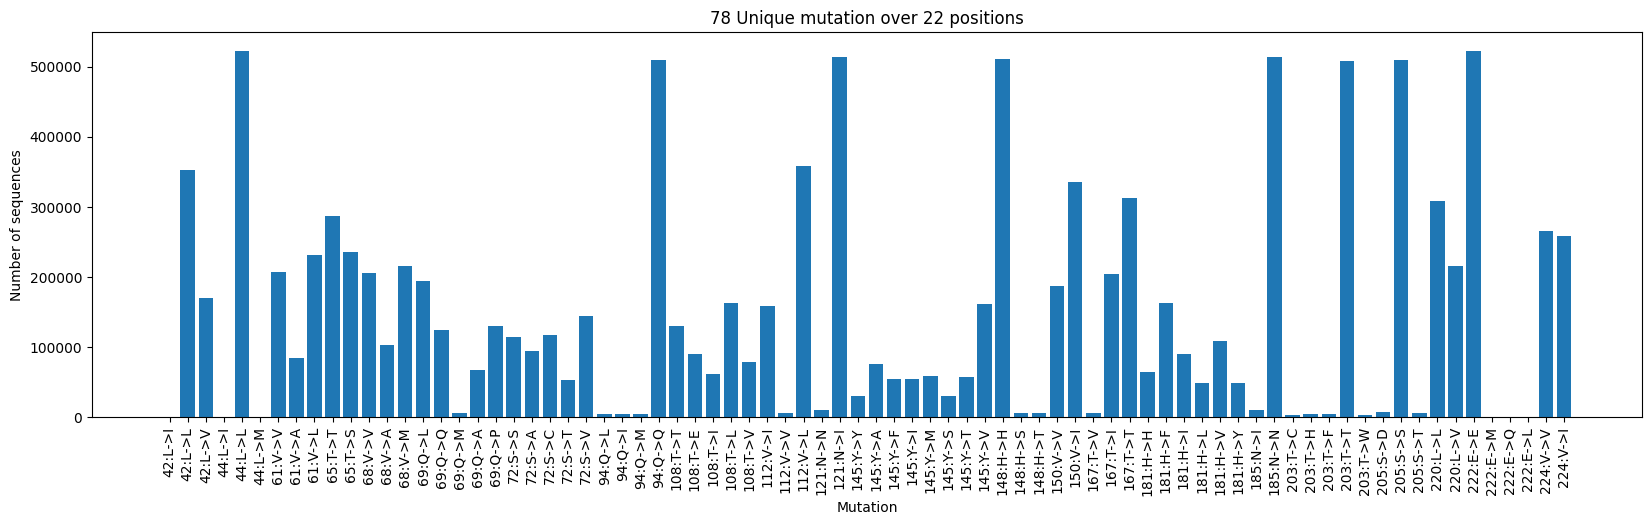

In [5]:
all_muts = [["%d:%s->%s" % (int(C[1:]), C[0] ,mut) for mut in pd.unique(df[C]).tolist()] for C in df.columns[si:(ei+1)]]

all_muts_flat = []

for m in all_muts:
    all_muts_flat.extend(m)

plt.figure(figsize=(20, 5))

plt.bar(height=one_hot.sum(axis=0), x=range(one_hot.shape[1]))
plt.xticks(range(one_hot.shape[1]), all_muts_flat, rotation=90)
plt.xlabel("Mutation")
plt.ylabel("Number of sequences")
plt.title("%d Unique mutation over %d positions" % (len(all_muts_flat), len(all_muts)))
plt.show()




In [ ]:
def run_python_script(args, cwd=None):
    """
    Executes a Python script with the given arguments list in the specified directory.
    Prints STDOUT in real time.
    The first element should be the script path, followed by its arguments.
    Example: ["other_script.py", "--foo", "bar"]
    """
    cmd = ["python"] + args
    print("Running command:", " ".join(cmd))
    process = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        cwd=cwd
    )

    while True:
        stdout_line = process.stdout.readline()
        if stdout_line:
            print(stdout_line, end="", flush=True)
        elif process.poll() is not None:
            break

    for line in process.stdout:
        print(line, end="", flush=True)

    stderr = process.stderr.read()
    if stderr:
        print("\n--- STDERR ---\n", stderr)

    process.stdout.close()
    process.stderr.close()
    return process

    

In [ ]:
args = ["./train_classifier_over_embeddings.py"]
run_python_script(args, cwd=os.path.abspath("./"))

In [ ]:
args = ["./train_classifier_over_ohe.py"]
run_python_script(args, cwd=os.path.abspath("./"))

0.8790436005625879

In [6]:
embeddings_dir = "results/classification_results/embeddings/"
csv_files = [name for name in os.listdir(embeddings_dir) if name.endswith('.csv')]
print(csv_files)



df_all = []

for model_name, prefix in {"esm8m": "8m_", "esm35m": "35m_", "esm650m": "650m_"}.items():
    filtered_csv_files = [f for f in csv_files if f.startswith(prefix)]
    for f in filtered_csv_files:
        df = pd.read_csv(os.path.join(embeddings_dir, f))
        df["model"] = model_name
        df_all.append(df)

df_all = pd.concat(df_all)


embeddings_dir = "results/classification_results/embeddings/gradient_boosting/"
csv_files = [name for name in os.listdir(embeddings_dir) if name.endswith('.csv')]
print(csv_files)



gdb_df_all = []

for model_name, prefix in {"esm35m": "35m_"}.items():
    filtered_csv_files = [f for f in csv_files if f.startswith(prefix)]
    for f in filtered_csv_files:
        df = pd.read_csv(os.path.join(embeddings_dir, f))
        df["model"] = model_name
        gdb_df_all.append(df)

gdb_df_all = pd.concat(gdb_df_all)

['8m_evaluation_train_on_1.csv', '650m_evaluation_train_on_3.csv', '8m_evaluation_train_on_4.csv', '35m_evaluation_train_on_5.csv', '8m_evaluation_train_on_2.csv', '650m_evaluation_train_on_4.csv', '35m_evaluation_train_on_4.csv', '650m_evaluation_train_on_5.csv', '650m_evaluation_train_on_1.csv', '35m_evaluation_train_on_2.csv', '8m_evaluation_train_on_3.csv', '35m_evaluation_train_on_3.csv', '35m_evaluation_train_on_1.csv', '8m_evaluation_train_on_5.csv', '650m_evaluation_train_on_2.csv']
['35m_evaluation_train_on_5.csv', '35m_evaluation_train_on_4.csv', '35m_evaluation_train_on_2.csv', '35m_evaluation_train_on_3.csv', '35m_evaluation_train_on_1.csv']


In [8]:
df_all

,tp,tn,fp,fn,precision,recall,f1,accuracy,roc,top_100_pct,test_mutations,train_mutations,classifier,model
0,624,4,82,1,0.883853,0.998400,0.937641,0.883263,0.541172,0.85,2,1,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm8m
1,2557,13,1161,2,0.687735,0.999218,0.814720,0.688454,0.545230,0.63,3,1,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm8m
2,5486,11,6696,1,0.450337,0.999818,0.620975,0.450795,0.507530,0.33,4,1,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm8m
3,7608,12,20679,0,0.268957,1.000000,0.423903,0.269267,0.526040,0.24,5,1,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm8m
4,7666,6,45471,0,0.144269,1.000000,0.252159,0.144365,0.530605,0.18,6,1,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm8m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,7451,5723,39754,215,0.157843,0.971954,0.271582,0.247897,0.607254,0.05,6,2,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm650m
4,5468,10376,68787,189,0.073638,0.966590,0.136851,0.186796,0.606058,0.04,7,2,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm650m
5,3011,15306,95793,154,0.030474,0.951343,0.059057,0.160304,0.588978,0.04,8,2,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm650m
6,1336,17671,105063,142,0.012557,0.903924,0.024769,0.153021,0.545123,0.00,9,2,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm650m


In [7]:
gdb_df_all

,tp,tn,fp,fn,precision,recall,f1,accuracy,roc,top_100_pct,test_mutations,train_mutations,classifier,model
0,5197,38581,6896,2469,0.429753,0.677929,0.526039,0.823777,0.847404,0.98,6,5,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm35m
1,3807,66255,12908,1850,0.227759,0.672972,0.340336,0.826008,0.835157,0.92,7,5,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm35m
2,1965,93790,17309,1200,0.101951,0.620853,0.175141,0.838015,0.802782,0.70,8,5,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm35m
3,636,104635,18099,842,0.033947,0.430311,0.062930,0.847511,0.698160,0.39,9,5,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm35m
4,216,87403,13734,583,0.015484,0.270338,0.029290,0.859549,0.606726,0.08,10,5,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm35m
0,6619,11651,9040,989,0.422696,0.870005,0.568960,0.645606,0.818758,1.00,5,4,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm35m
1,6826,24191,21286,840,0.242814,0.890425,0.381575,0.583652,0.821699,0.88,6,4,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm35m
2,4963,41435,37728,694,0.116254,0.877320,0.205303,0.547017,0.811851,0.74,7,4,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm35m
3,2668,58496,52603,497,0.048271,0.842970,0.091314,0.535287,0.786260,0.51,8,4,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm35m
4,1053,64395,58339,425,0.017730,0.712449,0.034598,0.526906,0.686665,0.20,9,4,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm35m


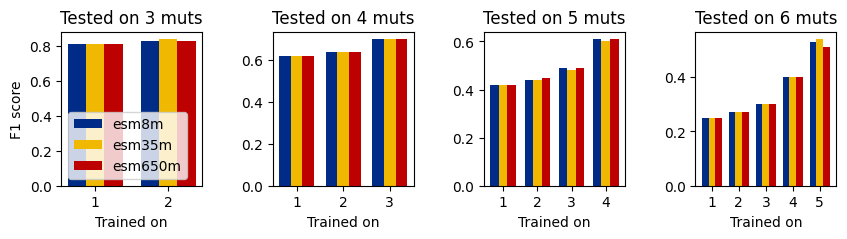

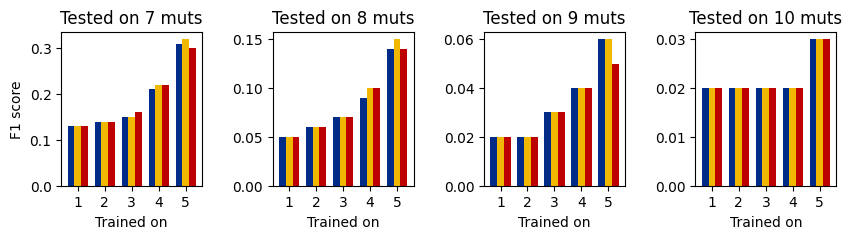

In [22]:

for nm in [3, 7]:

    col_size = 2
    row_size = col_size * 4 + 2
    fig, axs = plt.subplots(1, 4, figsize=(row_size, col_size))
    #axs = axs.flatten()

    plt.subplots_adjust(wspace=0.5)  # Increase horizontal spacing between subplots


    for i in range(nm,nm+4):

        sub_df = df_all[df_all["test_mutations"] == i]
        train_sub_df = sub_df[sub_df["train_mutations"] < i]

        row = (i - 3) // 4
        col = (i - 3) % 4

        n_train_muts = len(np.unique(train_sub_df["train_mutations"]))
        x = np.arange(n_train_muts)  # the label locations
        width = 0.25  # the width of the bars
        multiplier = 0 
        
        color_map = {
            "esm8m": "#002b87",
            "esm35m": "#f0b800",
            "esm650m": "#bd0000"
        }

        for model in ["esm8m", "esm35m", "esm650m"]:

            order = np.argsort(train_sub_df[(train_sub_df["model"] == model)]["train_mutations"])
            measurement = train_sub_df[(train_sub_df["model"] == model)].iloc[order]["f1"]
            measurement = measurement.round(2)
            offset = width * multiplier
            rects = axs[col].bar(x + offset, measurement, width, label=model, color=color_map.get(model, None))
            #axs[col].bar_label(rects, padding=3)
            multiplier += 1

        # Add some text for labels, title and custom x-axis tick labels, etc.
        if col == 0:
            axs[col].set_ylabel('F1 score')
            if nm == 3:
                axs[col].legend(loc='lower left', ncols=1)
                

        axs[col].set_title('Tested on %d muts' % i)
        axs[col].set_xticks(x + width, list(range(1,n_train_muts+1)))
        #axs[col].set_ylim(0,max(measurement)*1.3) 
        axs[col].set_xlabel('Trained on')

        precision = probabilities_by_mutations[i-1][1]
        #axs[col].axhline(y=precision, color='black', linestyle='--', linewidth=1)
        #Rotate bar value labels by 90 degrees


    plt.show()

In [9]:
ohe_dir = "./results/classification_results/ohe/200/"
csv_files = [name for name in os.listdir(ohe_dir) if name.endswith('.csv')]
print(csv_files)


ohe_classification = []

for f in csv_files:
    df = pd.read_csv(os.path.join(ohe_dir, f))
    df["model"] = "ohe"
    ohe_classification.append(df)

ohe_df = pd.concat(ohe_classification)



best_embedding_df = []
for j in range(1, 6):
    for i in range(j+1, 11):
    
        df = df_all[(df_all["test_mutations"] == i) & (df_all["train_mutations"] == j)]
        max_df = df.max().to_frame().T
        max_df["model"] = "esm"
        best_embedding_df.append(max_df)

best_embedding_df = pd.concat(best_embedding_df)


['ohe_evaluation_train_on_3.csv', 'ohe_evaluation_train_on_5.csv', 'ohe_evaluation_train_on_4.csv', 'ohe_evaluation_train_on_1.csv', 'ohe_evaluation_train_on_2.csv']


In [56]:
df

,tp,tn,fp,fn,precision,recall,f1,accuracy,roc,top_100_pct,test_mutations,train_mutations,classifier,model
4,313,80077,21060,486,0.014645,0.391740,0.028234,0.788632,0.643950,0.15,10,5,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm8m
4,305,82687,18450,494,0.016262,0.381727,0.031196,0.814158,0.650672,0.17,10,5,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm35m
4,350,76014,25123,449,0.013740,0.438048,0.026644,0.749137,0.635853,0.12,10,5,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm650m


In [11]:
gdb_df_all["model"] = "esm_gdb"
ohe_embedding_df_all = pd.concat([best_embedding_df, ohe_df, gdb_df_all])

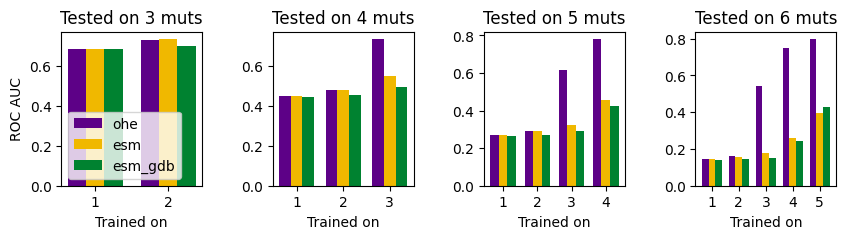

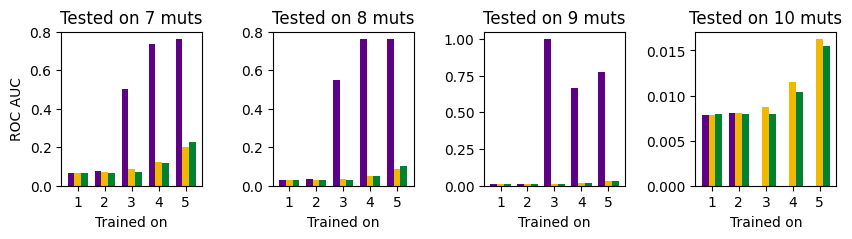

In [15]:

for nm in [3, 7]:

    col_size = 2
    row_size = col_size * 4 + 2
    fig, axs = plt.subplots(1, 4, figsize=(row_size, col_size))
    #axs = axs.flatten()

    plt.subplots_adjust(wspace=0.5)  # Increase horizontal spacing between subplots


    for i in range(nm,nm+4):

        sub_df = ohe_embedding_df_all[ohe_embedding_df_all["test_mutations"] == i]
        train_sub_df = sub_df[sub_df["train_mutations"] < i]

        row = (i - 3) // 4
        col = (i - 3) % 4

        n_train_muts = len(np.unique(train_sub_df["train_mutations"]))
        x = np.arange(n_train_muts)  # the label locations
        width = 0.25  # the width of the bars
        multiplier = 0 
        
        color_map = {            
            "esm": "#f0b800",
            "ohe": "#5d0187",
            "esm_gdb": "#008230"
        }

        for model in ["ohe", "esm", "esm_gdb"]:

            order = np.argsort(train_sub_df[(train_sub_df["model"] == model)]["train_mutations"])
            measurement = train_sub_df[(train_sub_df["model"] == model)].iloc[order]["precision"]
            
            measurement = measurement.round(2)
            offset = width * multiplier
            rects = axs[col].bar(x + offset, measurement, width, label=model, color=color_map.get(model, None))
            #axs[col].bar_label(rects, padding=3)
            multiplier += 1

        # Add some text for labels, title and custom x-axis tick labels, etc.
        if col == 0:
            axs[col].set_ylabel('ROC AUC')
            if nm == 3:
                axs[col].legend(loc='lower left', ncols=1)
                

        axs[col].set_title('Tested on %d muts' % i)
        axs[col].set_xticks(x + width, list(range(1,n_train_muts+1)))
        #axs[col].set_ylim(0,max(measurement)*1.3) 
        axs[col].set_xlabel('Trained on')

        precision = probabilities_by_mutations[i-1][1]
        #axs[col].axhline(y=precision, color='black', linestyle='--', linewidth=1)
        #Rotate bar value labels by 90 degrees


    plt.show()

In [55]:
train_sub_df

,tp,tn,fp,fn,precision,recall,f1,accuracy,roc,top_100_pct,test_mutations,train_mutations,classifier,model
0,799,0,101137,0,0.007838,1.0,0.015555,0.007838,0.515625,0.01,10,1,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm
0,717,15042,88582,109,0.008029,0.897372,0.015916,0.154332,0.522731,0.01,10,2,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm
0,640,30471,73329,176,0.008782,0.801001,0.017374,0.305035,0.587613,0.05,10,3,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm
0,502,59548,43976,313,0.011551,0.628285,0.022671,0.588938,0.64237,0.12,10,4,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm
0,350,82687,25123,494,0.016262,0.438048,0.031196,0.814158,0.650672,0.17,10,5,/home/labs/fleishman/itayta/new_fitness_repo/f...,esm
6,0,101137,0,799,NaN,0.0,NaN,0.992162,0.656891,0.16,10,3,ohe,ohe
4,0,101137,0,799,NaN,0.0,NaN,0.992162,0.684577,0.21,10,5,ohe,ohe
5,0,101137,0,799,NaN,0.0,NaN,0.992162,0.679634,0.19,10,4,ohe,ohe
8,799,0,101137,0,0.007838,1.0,0.015555,0.007838,0.497553,0.01,10,1,ohe,ohe
7,626,24345,76792,173,0.008086,0.783479,0.016007,0.244967,0.52442,0.0,10,2,ohe,ohe


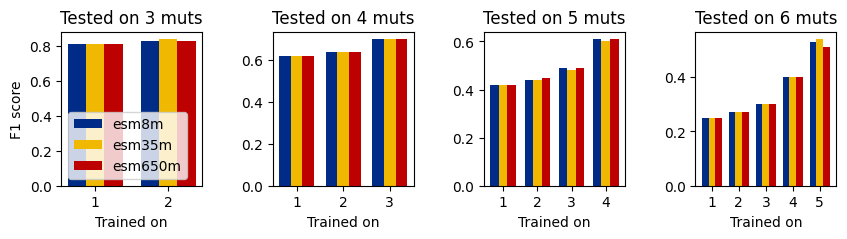

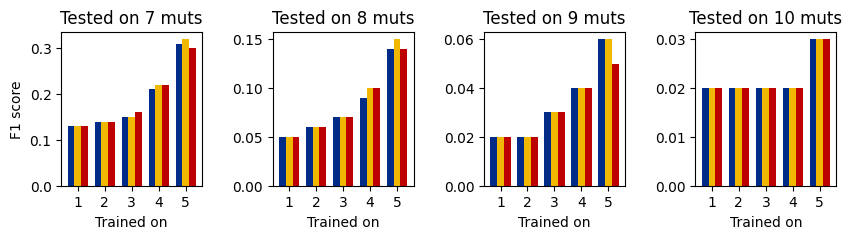

In [ ]:

for nm in [3, 7]:

    col_size = 2
    row_size = col_size * 4 + 2
    fig, axs = plt.subplots(1, 4, figsize=(row_size, col_size))
    #axs = axs.flatten()

    plt.subplots_adjust(wspace=0.5)  # Increase horizontal spacing between subplots


    for i in range(nm,nm+4):

        sub_df = df_all[df_all["test_mutations"] == i]
        train_sub_df = sub_df[sub_df["train_mutations"] < i]

        row = (i - 3) // 4
        col = (i - 3) % 4

        n_train_muts = len(np.unique(train_sub_df["train_mutations"]))
        x = np.arange(n_train_muts)  # the label locations
        width = 0.25  # the width of the bars
        multiplier = 0 
        
        color_map = {
            "esm8m": "#002b87",
            "esm35m": "#f0b800",
            "esm650m": "#bd0000"
        }

        for model in ["esm8m", "esm35m", "esm650m"]:

            order = np.argsort(train_sub_df[(train_sub_df["model"] == model)]["train_mutations"])
            measurement = train_sub_df[(train_sub_df["model"] == model)].iloc[order]["f1"]
            measurement = measurement.round(2)
            offset = width * multiplier
            rects = axs[col].bar(x + offset, measurement, width, label=model, color=color_map.get(model, None))
            #axs[col].bar_label(rects, padding=3)
            multiplier += 1

        # Add some text for labels, title and custom x-axis tick labels, etc.
        if col == 0:
            axs[col].set_ylabel('F1 score')
            if nm == 3:
                axs[col].legend(loc='lower left', ncols=1)
                

        axs[col].set_title('Tested on %d muts' % i)
        axs[col].set_xticks(x + width, list(range(1,n_train_muts+1)))
        #axs[col].set_ylim(0,max(measurement)*1.3) 
        axs[col].set_xlabel('Trained on')

        precision = probabilities_by_mutations[i-1][1]
        #axs[col].axhline(y=precision, color='black', linestyle='--', linewidth=1)
        #Rotate bar value labels by 90 degrees


    plt.show()